In [13]:
import numpy as np
import pandas as pf
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from clean_data import *
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [14]:
# convert salary first
data = pd.read_csv("data/data.csv")
data = convert_salary(data)

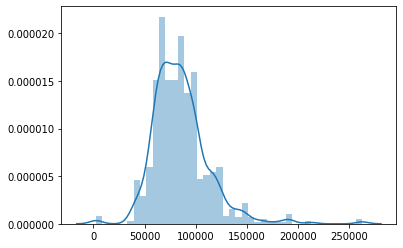

In [15]:
# see distribution of salary
salaries = data['salary'].values
salaries = np.sort(salaries)
sns.distplot(salaries)
plt.show()

In [16]:
# divide salary into 5 buckets
def salary_bucket(salary):
    if salary < 50000:
        return '<50,000'
    elif salary >= 50000 and salary < 100000:
        return '50,000-100,000'
    elif salary >= 100000 and salary < 150000:
        return '100,000-150,000'
    elif salary >= 150000 and salary <= 200000:
        return '150,000-200,000'
    else:
        return '>200,000'
    
data['salary_buckets'] = data['salary'].apply(lambda x: salary_bucket(x))

In [17]:
# drop useless columns
data = clean_location(data)
full_data = clean_requirements(data)

In [18]:
# drop useless columns
mod_data = full_data.drop(columns=['job_title', 'company_name', 'requirements', 'industry', 'requirements_cleaned'])
mod_data = pd.get_dummies(data=mod_data, columns=['job_category','city', 'province'])
mod_data =mod_data.drop(columns=['salary', 'salary_buckets'])

In [19]:
# extract features
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=1000)
corpus = full_data['requirements_cleaned'].values
bigram = bigram_vectorizer.fit_transform(corpus)
feature_names = bigram_vectorizer.get_feature_names()
words_df = pd.DataFrame(bigram.toarray(), columns=feature_names)

In [20]:
# split the data
X = pd.concat([mod_data, words_df], axis=1)
Y = full_data['salary_buckets']
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=20, test_size=0.3)

In [21]:
X

,abilities,ability,ability learn,ability work,able,able work,access,accounting,accurate,across,...,year preferred,year required,years,years experience,years preferred,years professional,years required,yes,yes alwayshiring,yes temporarily
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
946,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
947,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
948,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# logistic regression
mod_log = LogisticRegression()
mod_log = mod_log.fit(xtrain, ytrain)
log_acc = accuracy_score(ytest, mod_log.predict(xtest))
print("Log ACC: ", log_acc)

Log ACC:  0.8140350877192982


In [23]:
# random forest
mod_rf = RandomForestClassifier(random_state=33)
mod_rf = mod_rf.fit(xtrain, ytrain)
rf_acc = accuracy_score(ytest, mod_rf.predict(xtest))
print("RF ACC: ", rf_acc)

RF ACC:  0.7859649122807018


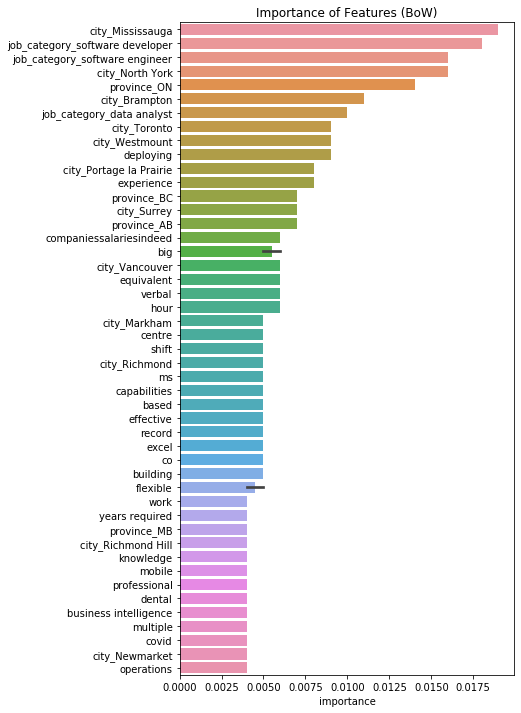

In [24]:
# visualize feature importance based on bag of wrods
# create feature importance data frame
df = pd.DataFrame(mod_rf.feature_importances_, columns=["importance"],
                  index=X.columns)
# sort by importance
df = df.sort_values('importance', ascending=False)
# plot top 20 features
plt.figure(figsize = (6,12))
sns.barplot(x=np.round(df.importance, 3)[0:50], y=df.index[0:50])
plt.title("Importance of Features (BoW)")
plt.show()

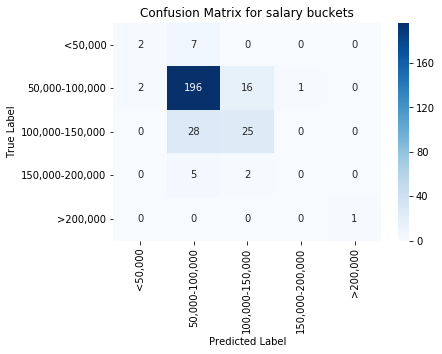

In [25]:
# bulid a confusion matrix
cm = confusion_matrix(ytest, mod_rf.predict(xtest), 
                      labels=['<50,000', '50,000-100,000', '100,000-150,000', '150,000-200,000', '>200,000'])
# plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
            xticklabels=['<50,000', '50,000-100,000', '100,000-150,000', '150,000-200,000', '>200,000'], 
            yticklabels=['<50,000', '50,000-100,000', '100,000-150,000', '150,000-200,000', '>200,000'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for salary buckets")
plt.show()

In [26]:
# when job_category and location are excluded
mod_data = full_data.drop(columns=['job_title', 'company_name', 'requirements', 'industry', 'requirements_cleaned'])
mod_data = mod_data.drop(columns=['job_category', 'city', 'province'])
mod_data =mod_data.drop(columns=['salary', 'salary_buckets'])

In [27]:
# split the data
X = pd.concat([mod_data, words_df], axis=1)
Y = full_data['salary_buckets']
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=20, test_size=0.3)

In [28]:
X

,abilities,ability,ability learn,ability work,able,able work,access,accounting,accurate,across,...,year preferred,year required,years,years experience,years preferred,years professional,years required,yes,yes alwayshiring,yes temporarily
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
946,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
947,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
948,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# logistic regression
mod_log = LogisticRegression()
mod_log = mod_log.fit(xtrain, ytrain)
log_acc = accuracy_score(ytest, mod_log.predict(xtest))
print("Log ACC: ", log_acc)

Log ACC:  0.8315789473684211


In [30]:
# random forest
mod_rf = RandomForestClassifier(random_state=33)
mod_rf = mod_rf.fit(xtrain, ytrain)
rf_acc = accuracy_score(ytest, mod_rf.predict(xtest))
print("RF ACC: ", rf_acc)

RF ACC:  0.8210526315789474


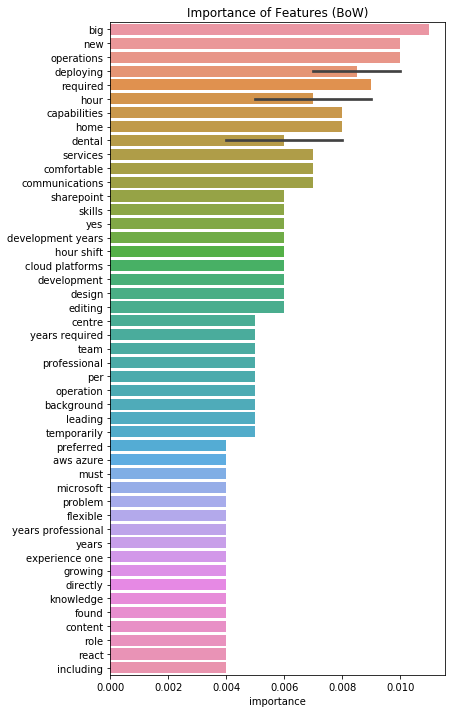

In [31]:
# visualize feature importance based on bag of wrods
# create feature importance data frame
df = pd.DataFrame(mod_rf.feature_importances_, columns=["importance"],
                  index=X.columns)
# sort by importance
df = df.sort_values('importance', ascending=False)
# plot top 20 features
plt.figure(figsize = (6,12))
sns.barplot(x=np.round(df.importance, 3)[0:50], y=df.index[0:50])
plt.title("Importance of Features (BoW)")
plt.show()